# Time Series Prediction

In [861]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
import json
import random
from keras import backend as K

## Read in Data

In [862]:
# Read in feature data
with open('../../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")
#feature_data.head()

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Feature not used: Total_CO2_Emission
Shape input features: (111, 40)


In [863]:
# Read in emission data
emission_data = pd.read_csv('../../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")

Shape output data: (111,)


In [864]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
    dataX, dataY = [], []
    if len(input) != len(output):
        raise ValueError('Input and ouput do not have same length!')
    for i in range(len(input)-look_back-horizon):
        dataX.append(input[i:(i+look_back)])
        dataY.append(output[(i+look_back):(i+look_back+horizon)])
    # Shuffle windows
    if shuffle is True:
        dataX, dataY = shuffle(dataX, dataY, random_state=0)
    return np.array(dataX), np.array(dataY)

In [865]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [866]:
scaler = StandardScaler()
scaler = MinMaxScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.7
shuffle = True

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

### Long Short-Term Memory

In [867]:
def train_lstm(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
    
    model = Sequential(name='LSTM')    
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    #model.add(LSTM(96, return_sequences=True, name="LSTM_3"))
    #model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    history = model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=1)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=1)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

### Convolutional Neural Network 

In [868]:
def train_cnn(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)
    
    model = Sequential(name='CNN') 
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='elu', name="Conv_1"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='elu', name="Conv_2"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', name="Conv_3"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_3'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='elu', name='Dense_1'))
    #model.add(Dense(8, activation='elu', name='Dense_2'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [869]:
# Features as input
trainX, trainY = sliding_window(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [870]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(59, 12, 40)
(59, 6)
(16, 12, 40)
(16, 6)


### Train Model

In [871]:
#Varying number of features

num_of_feats = 15
random_list = []

for i in range(num_of_feats):
        value = random.randint(0, 39)
        
        while value in random_list:
            value = random.randint(0, 39)
            
        random_list.append(value)        
        
random_list

[28, 25, 26, 0, 31, 37, 33, 18, 16, 13, 27, 38, 6, 1, 8]

In [872]:
trainX = trainX[:, :, random_list]
print(trainX.shape)
testX = testX[:, :, random_list]
print(testX.shape)

(59, 12, 15)
(16, 12, 15)


In [873]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan



# Train model and generate predictions
model, trainPredict, testPredict = train_cnn(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv1D)              (None, 8, 128)            9728      
_________________________________________________________________
batch_normalization_164 (Bat (None, 8, 128)            512       
_________________________________________________________________
Conv_2 (Conv1D)              (None, 6, 64)             24640     
_________________________________________________________________
batch_normalization_165 (Bat (None, 6, 64)             256       
_________________________________________________________________
Conv_3 (Conv1D)              (None, 5, 32)             4128      
_________________________________________________________________
batch_normalization_166 (Bat (None, 5, 32)             128       
_________________________________________________________________
flatten_58 (Flatten)         (None, 160)               0       

Epoch 44/250
47/47 [==============================] - 0s 467us/step - loss: 469.8069 - r2_keras: -17.0921 - val_loss: 809.6077 - val_r2_keras: -42.0460
Epoch 45/250
47/47 [==============================] - 0s 410us/step - loss: 467.9161 - r2_keras: -18.9533 - val_loss: 714.9394 - val_r2_keras: -36.9756
Epoch 46/250
47/47 [==============================] - 0s 511us/step - loss: 401.0523 - r2_keras: -14.7860 - val_loss: 651.8838 - val_r2_keras: -33.4895
Epoch 47/250
47/47 [==============================] - 0s 302us/step - loss: 389.9196 - r2_keras: -14.2326 - val_loss: 652.7164 - val_r2_keras: -33.0704
Epoch 48/250
47/47 [==============================] - 0s 340us/step - loss: 344.1077 - r2_keras: -12.1678 - val_loss: 613.4447 - val_r2_keras: -30.4195
Epoch 49/250
47/47 [==============================] - 0s 511us/step - loss: 292.2708 - r2_keras: -9.9886 - val_loss: 541.3457 - val_r2_keras: -26.7576
Epoch 50/250
47/47 [==============================] - 0s 373us/step - loss: 301.4284 - r2

Epoch 99/250
47/47 [==============================] - 0s 441us/step - loss: 21.7460 - r2_keras: 0.1913 - val_loss: 30.9900 - val_r2_keras: -0.3956
Epoch 100/250
47/47 [==============================] - 0s 270us/step - loss: 19.9109 - r2_keras: 0.2345 - val_loss: 22.5816 - val_r2_keras: -0.0373
Epoch 101/250
47/47 [==============================] - 0s 277us/step - loss: 24.0209 - r2_keras: 0.0747 - val_loss: 22.9998 - val_r2_keras: -0.0550
Epoch 102/250
47/47 [==============================] - 0s 340us/step - loss: 16.9942 - r2_keras: 0.3623 - val_loss: 29.5854 - val_r2_keras: -0.3076
Epoch 103/250
47/47 [==============================] - 0s 391us/step - loss: 15.8620 - r2_keras: 0.3947 - val_loss: 39.9590 - val_r2_keras: -0.7374
Epoch 104/250
47/47 [==============================] - 0s 516us/step - loss: 20.2031 - r2_keras: 0.2384 - val_loss: 36.1025 - val_r2_keras: -0.6553
Epoch 105/250
47/47 [==============================] - 0s 340us/step - loss: 23.1407 - r2_keras: 0.0625 - val_los

47/47 [==============================] - 0s 518us/step - loss: 8.7314 - r2_keras: 0.6620 - val_loss: 11.4539 - val_r2_keras: 0.5177
Epoch 155/250
47/47 [==============================] - 0s 426us/step - loss: 10.8389 - r2_keras: 0.5778 - val_loss: 11.6396 - val_r2_keras: 0.4648
Epoch 156/250
47/47 [==============================] - 0s 341us/step - loss: 6.3760 - r2_keras: 0.7530 - val_loss: 7.4103 - val_r2_keras: 0.6862
Epoch 157/250
47/47 [==============================] - 0s 340us/step - loss: 9.5605 - r2_keras: 0.6192 - val_loss: 8.3920 - val_r2_keras: 0.6206
Epoch 158/250
47/47 [==============================] - 0s 511us/step - loss: 7.6368 - r2_keras: 0.7089 - val_loss: 6.9400 - val_r2_keras: 0.6807
Epoch 159/250
47/47 [==============================] - 0s 511us/step - loss: 10.8745 - r2_keras: 0.5703 - val_loss: 10.3260 - val_r2_keras: 0.5561
Epoch 160/250
47/47 [==============================] - 0s 429us/step - loss: 7.0933 - r2_keras: 0.7317 - val_loss: 9.4397 - val_r2_keras: 0

### Prediction and Plot

Forecast: [[75.37651  72.63509  72.68591  63.697987 58.265923 56.467224]]


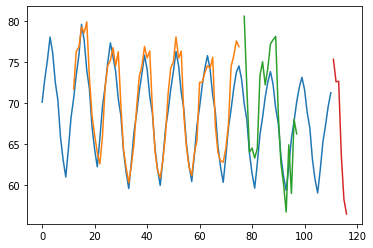

In [874]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
#X = np.zeros((1, look_back, feature_data.shape[1]))
X = np.zeros((1, look_back, num_of_feats))
#X[0] = feature_data[len(feature_data)-look_back:, :]
X[0] = feature_data[len(feature_data)-look_back:, :num_of_feats]
predict = model.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()